In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from MPCProblem import MPCProblem
from util import *
import cvxpy as cp
import warnings
import itertools
import time
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
import graphviz
import pydotplus
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import brier_score_loss
from scipy import stats
import matplotlib.dates as md
import os
warnings.filterwarnings('ignore')

In [2]:
peak_flows = [310.995288, 95.952598, 140.088000, 67.040000, 77.467000, 83.829000] # kcfs
flood_pools = [750, 170, 340, 350, 170, 450] # TAF
sites = ['ORDC1', 'NBBC1', 'NDPC1', 'EXQC1', 'FRAC1', 'NMSC1']
Rmax_con = [150, 50, 9, 6, 8, 8]
RR_con = [50, 14, 9, 6, 8, 8]

baseline_TOCS = [733, 211, 558, 285, 319, 355]
perfect_TOCS = [0, 0, 449, 212, 199, 234]
hefs_TOCS = [0, 0, 481, 215, 239, 282]

sites = ['ORDC1', 'NBBC1', 'NDPC1', 'EXQC1', 'FRAC1', 'NMSC1']
fcst = 'hefs'

In [3]:
# Figure 7a will be one of the exported png files ORDC1_100FP.png
df_Rmax_thres = pd.DataFrame(index = sites)
for FP_per in range(100, 0, -10):
    
    Rmax_thres = []
    for site_n in range(6):
    
        site = sites[site_n]

        # read CART results
        df_input = pd.read_csv('output/CART_input_%s_LT_full.csv' %site, index_col = 0)
        df_input.columns = ['Rmax', 'RR', 'LT',
                            'max_above_TOCS_baseline',
                            'max_above_TOCS_perfect',
                            'max_above_TOCS_hefs']
        
        include_NL = True
        scale_to_peak = True
        binary_class = True
        
        X = df_input[['Rmax','RR','LT']]
        
        if scale_to_peak:
            scale = peak_flows[site_n] * 0.01
        else:
            scale = 1
        
        X[['Rmax','RR']] = (X[['Rmax','RR']]/scale).round(1)

        y = df_input['max_above_TOCS_hefs']
        
        col = 'max_above_TOCS_hefs'
        
        b_cut = 0.01 * FP_per * flood_pools[site_n]
        p_cut = 0.25 * flood_pools[site_n]
        
        if binary_class:
            y = y.where(df_input[col]>=b_cut, 0)
            y = y.where(df_input[col]<b_cut, 1)
        
            class_names = ['better', 'worse']
        
        # best: less than p_cut
        # better: between p_cut and b_cut
        # worse: greater than b_cut
        
        else: # 3 classes better/worse/best
            y = y.where((df_input[col]>=p_cut) | (df_input[col]==0), 2)
            y = y.where((df_input[col]<=b_cut), 1)
            y = y.where((df_input[col]<p_cut) | (df_input[col]>b_cut), 0)
        
            class_names = ['better','worse','best']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)
        
        clf = tree.DecisionTreeClassifier(max_depth = 3)
        clf = clf.fit(X_train, y_train)
        
        dot_data = tree.export_graphviz(clf, feature_names = X.columns, class_names = class_names, 
                                               filled = True, rotate = False, rounded = True, leaves_parallel = False,
                                               impurity = False, label = 'root', precision = 0)
        dot_data = graphviz.Source(dot_data, format = 'png')
        dot_data.render('tree_plot_test/%s_%sFP' %(site, FP_per), view = False)
        os.remove('tree_plot_test/%s_%sFP' %(site, FP_per))

        Rmax_thres.append(clf.tree_.threshold[0])

    df_Rmax_thres[str(FP_per)] = Rmax_thres

[0. 0. 0. ... 0. 0. 0.]
Training accuracy: 0.9997619047619047
Testing accuracy: 0.9994444444444445
[0. 0. 0. ... 0. 0. 0.]
Training accuracy: 1.0
Testing accuracy: 1.0
[0. 0. 0. ... 1. 0. 1.]
Training accuracy: 0.9916666666666667
Testing accuracy: 0.9894444444444445
[0. 0. 1. ... 1. 0. 1.]
Training accuracy: 0.9688095238095238
Testing accuracy: 0.9655555555555555
[0. 0. 1. ... 1. 0. 1.]
Training accuracy: 0.9202380952380952
Testing accuracy: 0.9188888888888889
[0. 0. 1. ... 1. 0. 1.]
Training accuracy: 0.9066666666666666
Testing accuracy: 0.9111111111111111
[0. 0. 1. ... 1. 0. 1.]
Training accuracy: 0.9216666666666666
Testing accuracy: 0.9272222222222222
[1. 0. 1. ... 1. 0. 1.]
Training accuracy: 0.9554761904761905
Testing accuracy: 0.9538888888888889
[1. 0. 1. ... 1. 0. 1.]
Training accuracy: 0.9657142857142857
Testing accuracy: 0.9555555555555556
[1. 1. 1. ... 1. 1. 1.]
Training accuracy: 0.975
Testing accuracy: 0.9761111111111112


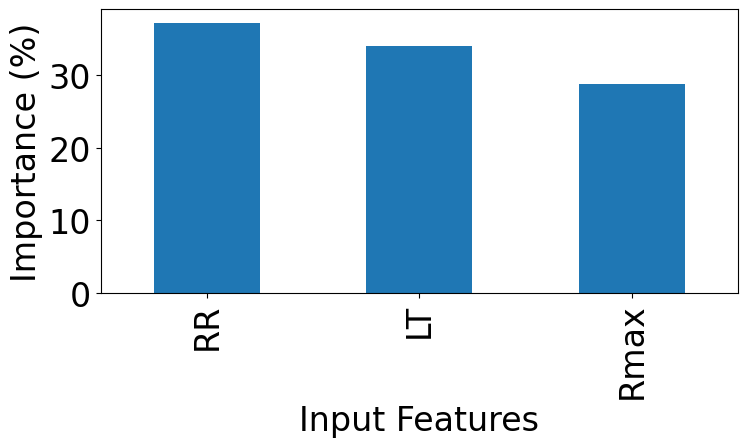

In [36]:
fcst = 'hefs'
site = 'ORDC1'

df_input_combine = pd.DataFrame()
for site_n in range(6):
    site = sites[site_n]
    # 1997
    df_input = pd.read_csv('output/CART_input_%s_LT_full.csv' %site, index_col = 0)
    # 2017
    # df_input = pd.read_csv('%s_CART_input_Feb2017.csv' %site, index_col = 0)
    df_input.columns = ['Rmax', 'RR', 'LT',
                        'max_above_TOCS_baseline',
                        'max_above_TOCS_perfect',
                        'max_above_TOCS_hefs']

    # add site column and covert to % peak flow and % flood pool
    df_input['site'] = site
    df_input['Rmax'] = 100*df_input['Rmax']/peak_flows[site_n]
    df_input['RR'] = 100*df_input['RR']/peak_flows[site_n]

    col_TOCS = ['max_above_TOCS_baseline','max_above_TOCS_perfect','max_above_TOCS_hefs']
    df_input[col_TOCS] = 100*df_input[col_TOCS]/flood_pools[site_n]

    df_input_combine = pd.concat([df_input_combine, df_input])

df_input_combine = df_input_combine.reset_index(drop = True)

# mess around
Rmax_thres = []
RR_thres = []
LT_thres = []

df_tree_thres = pd.DataFrame()
df_acc = pd.DataFrame()
df_feat_imp = pd.DataFrame()

y_count = []

for FP in range(100, 0, -10):
    
    # df_input = df_input_combine.copy()
    df_input = df_input_combine[df_input_combine['site']==site]

    X = df_input[['Rmax','RR','LT']]
    y = df_input['max_above_TOCS_%s' %fcst]

    col = 'max_above_TOCS_%s' %fcst

    FP = FP

    y = y.where(df_input[col]>=FP, 0)
    y = y.where(df_input[col]<FP, 1)

    y_count.append(y.value_counts())

    class_names = ['better', 'worse']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

        
    clf = tree.DecisionTreeClassifier(max_depth = 3)
    clf = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    
    print(y_pred)
    print("Training accuracy:", metrics.accuracy_score(y_train, y_pred_train))
    print("Testing accuracy:", metrics.accuracy_score(y_test, y_pred))

    df_acc["FP%s" %FP] = [metrics.accuracy_score(y_train, y_pred_train), metrics.accuracy_score(y_test, y_pred)]
    
    df_tree = pd.DataFrame()
    df_tree['feature'] = clf.tree_.feature
    df_tree['threshold'] = np.round(clf.tree_.threshold, 0)
 
    
    Rmax_thres.append(clf.tree_.threshold[0])
    
    df_feat_imp['FP%s' %(FP)] = 100 * clf.feature_importances_


# Figure 7c
fontsize = 24
plt.rcParams.update({'font.size': fontsize})
df_feat_imp = pd.DataFrame({'Importance': 100 * clf.feature_importances_}, index = X.columns)
fig, ax = plt.subplots(figsize = (8,5))
df_feat_imp.sort_values("Importance", ascending = False).plot.bar(legend = False, ax = ax)
ax.set_xlabel('Input Features')
ax.set_ylabel('Importance (%)')
plt.tight_layout()

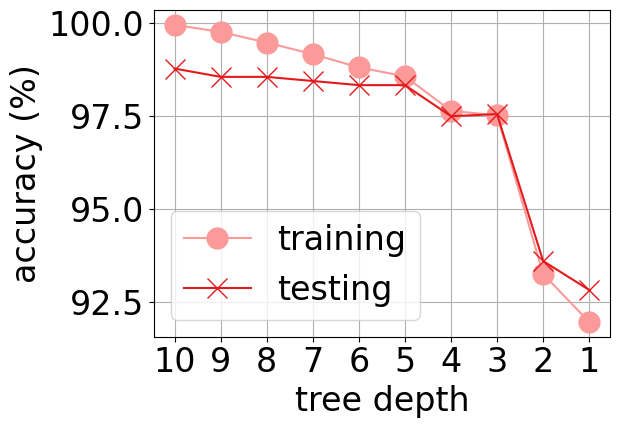

In [31]:
# Figure 7b
train_acc = []
test_acc = []

for d in range(10,0,-1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state  = 5)
    
    clf = tree.DecisionTreeClassifier(max_depth = d)
    clf = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    

    train_acc.append(metrics.accuracy_score(y_train, y_pred_train))
    test_acc.append(metrics.accuracy_score(y_test, y_pred))

df_result = pd.DataFrame({"train_acc":train_acc, "test_acc": test_acc})

df_result.index = range(0,10,1)
df_result.sort_index()

fontsize = 24
plt.rcParams.update({'font.size': fontsize})
fig, ax = plt.subplots()
df_plot = 100*df_result.sort_index()
df_plot['train_acc'].plot(marker = "o", markersize = 15, color = sns.color_palette('Paired')[4:5])
df_plot['test_acc'].plot(marker = "x", markersize = 15, color = sns.color_palette('Paired')[5:6])
ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy (%)')
ax.legend(['training','testing'])
ax.set_xlabel('tree depth')
ax.set_xticks(range(0,10,1))
ax.set_xticklabels(range(10,0,-1))
ax.grid()
plt.tight_layout()

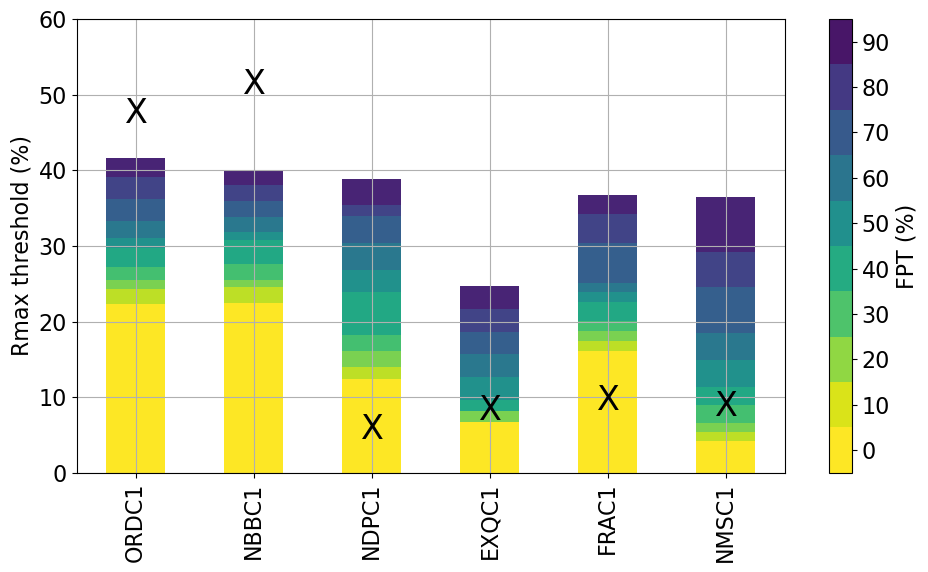

In [9]:
# Figure 8

Rmax_con = [150, 50, 9, 6, 8, 8]
RR_con = [50, 14, 9, 6, 8, 8]

baseline_TOCS = [733, 211, 558, 285, 319, 355]
perfect_TOCS = [0, 0, 449, 212, 199, 234]
hefs_TOCS = [0, 0, 481, 215, 239, 282]

df_useful = pd.DataFrame({"peak_flow":peak_flows,"flood_pool":flood_pools,
                          "Rmax_con": Rmax_con, "RR_con":RR_con,
                          "baseline_TOCS":baseline_TOCS,
                          "perfect_TOCS":perfect_TOCS,
                          "hefs_TOCS":hefs_TOCS}, index = sites)

ratio = []
for n in range(6):
    ratio.append(peak_flows[n] * kcfs_to_tafd / flood_pools[n])

# peak flow taf
df_useful['peak_flow_taf'] = df_useful['peak_flow']*kcfs_to_tafd

offset = 0.05
fontsize = 16
plt.rcParams.update({'font.size': fontsize})
fig, ax = plt.subplots(figsize = (10,6))

# for i in range(len(df_plot)):
    # df_plot.iloc[-(i+1)].plot.bar(ax = ax, color = sns.color_palette("tab10")[-(i+1)], alpha = 1)

df_plot = df_Rmax_thres.transpose()
df_plot.index = range(0,100,10)

FN_per = range(10, 110, 10)
for i in range(len(df_plot)):
    # df_plot.iloc[-(i+1)].plot.bar(ax = ax, color = sns.color_palette("viridis", n_colors = 10)[i], alpha = 1)
    df_plot.iloc[-(i+1)].plot.bar(ax = ax, color = sns.color_palette("viridis", as_cmap = True)((0+FN_per[i])/100),alpha = 1)

from matplotlib.colors import ListedColormap, BoundaryNorm

# norm = BoundaryNorm(np.arange(0, 100, 10), 10)
norm = plt.Normalize(10, 100)
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
cb = ax.figure.colorbar(sm, ax=ax, boundaries = range(0,110,10), label = 'FPT (%)')

# Set the new tick locations
cb.set_ticks(range(5,100,10))
cb.set_ticklabels(range(0,100,10))

# Rmax constraints...
fs = 24

ax.set_ylabel('Rmax threshold (%)')

ax.set_ylim(0,60)
for n in range(6):
    ax.text(n-offset-0.04,-2+100*df_useful['Rmax_con'].iloc[n]/peak_flows[n], 
              "X", fontsize=fs, color='black') # Rmax constraints

ax.grid()
plt.tight_layout()